In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
%matplotlib inline

# Our model

We observe a variable $X$ which is a 1D position of an object


$$\begin{align*}
X &\sim \mathcal{N}(\mu, 1)\\
\mu &\sim \mathcal{N}(0,3)& \;\;\;\text{prior on }\mu = P(\mu)\\
x_0 &= 1.5&\;\;\;\text{a measurement}\\
\end{align*}$$

The posterior is

$$P(\mu|x_0) = \frac{P(x_0|\mu) P (\mu)}{P(x_0)}$$


In [35]:
# real (and unknown) parameter
real_mu = 0.8

# possible range of values for mu
mu_support = np.r_[-10,10]

eps=1e-10

In [36]:
class Model:
    
    def __init__(self, mu):
        self.mu = mu
        self.dist = stats.norm(loc=mu, scale=1)
        
    def rvs(self, n):
        return self.dist.rvs(n)
    
    def log_prob(self, x):
        return np.log(self.dist.pdf(x) + eps)
    
    # loglikelihood on mu
    @classmethod
    def log_likelihood(cls, mu, x):
        return cls(mu).log_prob(x)

# An observation

In [37]:
#x = Model(real_mu).rvs(1)[0]
# a very extreme (low probability) observation
x = 2

In [38]:
# fix the likelihood to the observed data, so that it is
# only a function of mu
log_likelihood = lambda mu: Model.log_likelihood(mu, x)

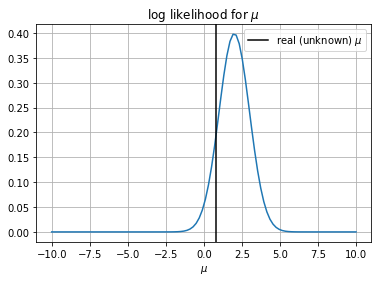

In [39]:
rmu = np.linspace(*mu_support, 100)
plt.plot(rmu, [np.exp(log_likelihood(mu)) for mu in rmu])
plt.axvline(real_mu, color="black", label=r"real (unknown) $\mu$")
plt.legend();
plt.grid(); plt.xlabel(r"$\mu$"); plt.title(r"log likelihood for $\mu$");

In [40]:
# the posterior (using Bayes theorem)
def get_logposterior_fn(loglikelihood_fn, logprior_fn, support, integration_intervals=1000):
    assert len(support)==2

    # Montecarlo computation of the integral
    xr = np.linspace(*support, integration_intervals)
    Z = np.log(np.sum([np.exp(loglikelihood_fn(x) + logprior_fn(x)) for x in xr]) * (xr[1]-xr[0]))
    posterior_fn = lambda x: loglikelihood_fn(x) + logprior_fn(x) -  Z
    return posterior_fn

In [41]:
def plot_logprobs(logprior, logposterior):
    rmu = np.linspace(*mu_support,100)

    for ax,i in subplots(4, usizex=5, n_cols=2):
        if i in [0,2]:
            p = logprior if i==0 else lambda x: np.exp(logprior(x))
            plt.plot(rmu, [p(mu) for mu in rmu])
            plt.axvline(x, color="black",  ls="--", label=r"measurement")
            plt.grid();   
            plt.title(("log " if i==0 else "")+"prior probability (analitical)")
        if i in [1,3]:
            p = logposterior if i==1 else lambda x: np.exp(logposterior(x))
            plt.plot(rmu, [p(mu) for mu in rmu])
            plt.axvline(real_mu, color="black", label=r"real (unknown) $\mu$")
            plt.axvline(x, color="black",  ls="--", label=r"measurement")
            plt.title(("log " if i==1 else "")+"posterior probability (analitical)")
            plt.grid(); plt.legend();

        plt.xlabel(r"$\mu$")
    plt.tight_layout()

In [42]:
log_prior = lambda mu: np.log(stats.norm(loc=-2,scale=3).pdf(mu) + eps)


In [43]:
log_posterior = get_logposterior_fn(log_likelihood, log_prior, mu_support)

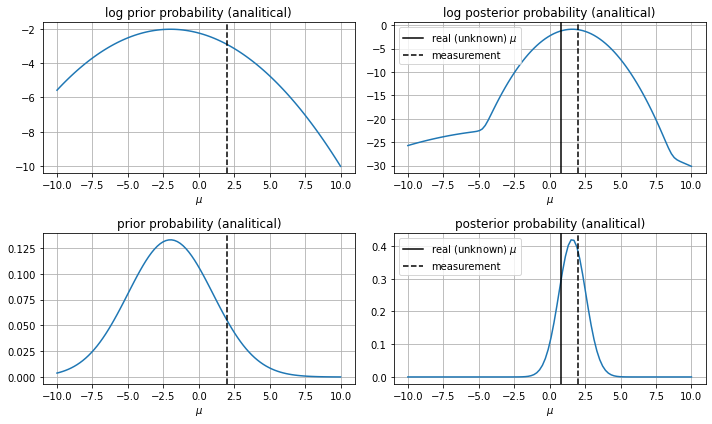

In [44]:
plot_logprobs(log_prior, log_posterior)

In [45]:
## check the integral of the posterior adds up to 1
## we do this for sanity, as numerical errors computing the 
## integral in bayes theorem might arise very easily
rmu = np.linspace(mu_support[0] - 10, mu_support[1] + 10, 1000)
dmu = rmu[1] - rmu[0]
np.sum([np.exp(log_posterior(mu))*dmu for mu in rmu])

1.0000000000067457

## posterior mean and std

through expectations

In [46]:
# mean
mean_ev = np.sum([np.exp(log_posterior(mu))*mu*dmu for mu in rmu])
mean_ev

1.5999999943656429

In [47]:
# std
std_ev = np.sqrt(np.sum([np.exp(log_posterior(mu))*(mu-mean_ev)**2*dmu for mu in rmu]))
std_ev

0.9486833178763522